# Intermediate scikit-learn



Today we examine a few important ideas in data science and machine learning. They are:

1.  Data preprocessing. We mostly focus on how to scale data so that each feature has about the same scale.
2.  How to combine many data processing/fitting steps into a pipeline that is easy to work with
3.  How to use k-fold validation to make sure your model fit doesn't depend too much on one data set sample.
4.  Automating the optimization of model parameters using cross-validation.



## Data preprocessing



When your features have varying orders of magnitude, it is often a good idea to standardize them. That makes each feature have a similar importance. Some algorithms even expect that the input features have been standardized (e.g. PCA, and many kinds of regularization). The two most common approaches are:

-   **zero-mean, unit variance:** You subtract the mean of each column, and normalize by the variance of the column
-   **min-max:** you scale the column so that the minimum value maps to a constant (often 0 or -1), and the maximum value maps to a constant (often 1).

`sklearn` provides a [preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) module to make this "simple".

```{index} preprocessing
```

We will explore this with this data set which represents the energy of a Cu dimer as a function of the distance between the two atoms. Our goal is to develop a model that fits this. We know some physics about this system, and that is as the atoms approach each other, they should strongly repel each other, and the energy would go to infinity, and as the atoms get far apart, they cannot interact, so the energy should go to a constant. You might think the energy should go to zero,, but this depends on what reference system the energy zero is defined for. The zero in this system is defined as the minimum energy for *bulk* Cu in an fcc unit cell. So, this system levels out at an energy that is much higher than that.



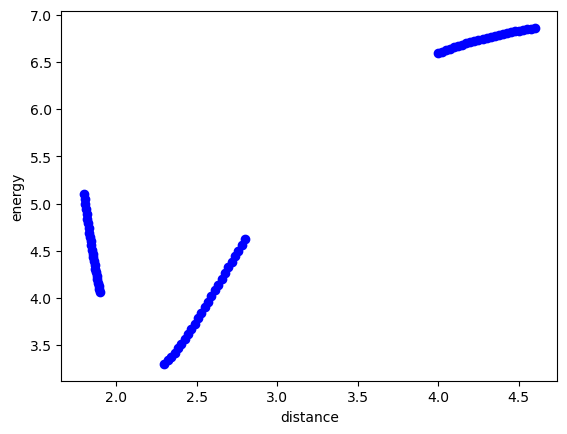

In [1]:
import json

with open("data.json") as f:
    data = json.load(f)

import matplotlib.pyplot as plt

plt.plot(data["distance"], data["energy"], "bo")
plt.xlabel("distance")
plt.ylabel("energy");

First, let's make some columns. Instead of manually creating these, let's leverage the capability of `sklearn` to build the features for us. Here is an example of a second order polynomial.

```{index} PolynomialFeatures
```

In [2]:
import numpy as np

X = np.array([data["distance"]]).T

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
poly.fit_transform(X)

array([[ 1.        ,  1.8       ,  3.24      ],
       [ 1.        ,  1.80416667,  3.25501736],
       [ 1.        ,  1.80833333,  3.27006944],
       [ 1.        ,  1.8125    ,  3.28515625],
       [ 1.        ,  1.81666667,  3.30027778],
       [ 1.        ,  1.82083333,  3.31543403],
       [ 1.        ,  1.825     ,  3.330625  ],
       [ 1.        ,  1.82916667,  3.34585069],
       [ 1.        ,  1.83333333,  3.36111111],
       [ 1.        ,  1.8375    ,  3.37640625],
       [ 1.        ,  1.84166667,  3.39173611],
       [ 1.        ,  1.84583333,  3.40710069],
       [ 1.        ,  1.85      ,  3.4225    ],
       [ 1.        ,  1.85416667,  3.43793403],
       [ 1.        ,  1.85833333,  3.45340278],
       [ 1.        ,  1.8625    ,  3.46890625],
       [ 1.        ,  1.86666667,  3.48444444],
       [ 1.        ,  1.87083333,  3.50001736],
       [ 1.        ,  1.875     ,  3.515625  ],
       [ 1.        ,  1.87916667,  3.53126736],
       [ 1.        ,  1.88333333,  3.546

You can see that there are some orders of magnitude variation across the columns. We can use standard methods in sklearn to scale these features. This is the *zero-mean and unit-variance* approach.

```{index} preprocessing - scale
```

In [3]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(poly.fit_transform(X))
X_scaled

array([[ 0.        , -1.05831672, -0.94881821],
       [ 0.        , -1.05430795, -0.94653852],
       [ 0.        , -1.05029917, -0.94425357],
       [ 0.        , -1.0462904 , -0.94196335],
       [ 0.        , -1.04228162, -0.93966786],
       [ 0.        , -1.03827284, -0.93736709],
       [ 0.        , -1.03426407, -0.93506105],
       [ 0.        , -1.03025529, -0.93274975],
       [ 0.        , -1.02624652, -0.93043317],
       [ 0.        , -1.02223774, -0.92811132],
       [ 0.        , -1.01822897, -0.9257842 ],
       [ 0.        , -1.01422019, -0.92345181],
       [ 0.        , -1.01021142, -0.92111415],
       [ 0.        , -1.00620264, -0.91877122],
       [ 0.        , -1.00219387, -0.91642301],
       [ 0.        , -0.99818509, -0.91406954],
       [ 0.        , -0.99417631, -0.91171079],
       [ 0.        , -0.99016754, -0.90934678],
       [ 0.        , -0.98615876, -0.90697749],
       [ 0.        , -0.98214999, -0.90460293],
       [ 0.        , -0.97814121, -0.902

We can check that we get what we asked for:



In [4]:
X_scaled.mean(), X_scaled.std(axis=0)

(-6.315935428978668e-17, array([0., 1., 1.]))

We can also transform to min-max this way, the default here is to scale between 0 and 1.



In [5]:
minmax = preprocessing.MinMaxScaler()
minmax.fit_transform(poly.fit_transform(X))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.48809524e-03, 8.38022383e-04],
       [0.00000000e+00, 2.97619048e-03, 1.67798239e-03],
       [0.00000000e+00, 4.46428571e-03, 2.51988002e-03],
       [0.00000000e+00, 5.95238095e-03, 3.36371528e-03],
       [0.00000000e+00, 7.44047619e-03, 4.20948816e-03],
       [0.00000000e+00, 8.92857143e-03, 5.05719866e-03],
       [0.00000000e+00, 1.04166667e-02, 5.90684679e-03],
       [0.00000000e+00, 1.19047619e-02, 6.75843254e-03],
       [0.00000000e+00, 1.33928571e-02, 7.61195592e-03],
       [0.00000000e+00, 1.48809524e-02, 8.46741691e-03],
       [0.00000000e+00, 1.63690476e-02, 9.32481554e-03],
       [0.00000000e+00, 1.78571429e-02, 1.01841518e-02],
       [0.00000000e+00, 1.93452381e-02, 1.10454257e-02],
       [0.00000000e+00, 2.08333333e-02, 1.19086372e-02],
       [0.00000000e+00, 2.23214286e-02, 1.27737863e-02],
       [0.00000000e+00, 2.38095238e-02, 1.36408730e-02],
       [0.00000000e+00, 2.52976

There are other ways to do the scaling, and sometimes you have to be careful that you don't do bad things. For example if you have very sparse data, it may not make sense to center it.



### Pipeline



These steps can be combined in what is called a `pipeline`. The idea is that data goes into the pipe and is transformed in a series of steps, and the results come out the end of the pipe. The code above can be condensed into this concept like this. Here we also perform a linear regression.

```{index} pipeline
```

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(4)
scaler = preprocessing.StandardScaler()
model = linear_model.LinearRegression()

X = np.array([data["distance"]]).T
y = np.array([data["energy"]]).T

pipe = Pipeline([("poly", poly), ("scale", scaler), ("linregress", model)])

pipe.fit(X, y)

Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                ('scale', StandardScaler()),
                ('linregress', LinearRegression())])

Here, we can use visualization to see how well the fit works with this data.



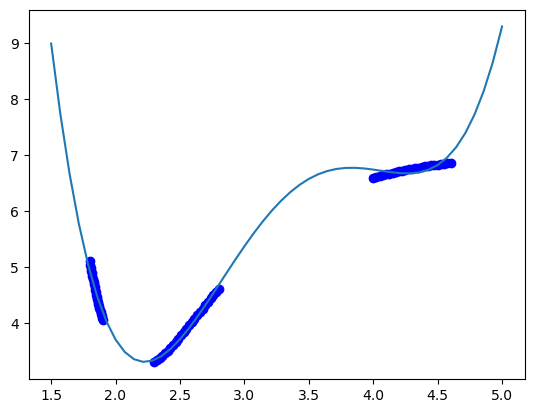

In [7]:
dfit = np.linspace(1.5, 5)

plt.plot(data["distance"], data["energy"], "bo", dfit, pipe.predict(dfit[:, None]));

The model sort of gets the right idea, but you can see there are issues with it. The local maximum near 3.7 is not real, and the increase in energy past d=4.5 is also not physically correct. We can work with different polynomial orders to see if that is fixable. The polynomial order is considered a *hyperparameter* here.



## k-fold validation / cross-validation

```{index} k-fold
```

[https://scikit-learn.org/stable/modules/cross_validation.html](https://scikit-learn.org/stable/modules/cross_validation.html)

We have 75 data points, and the best thing to do in training would be to split the data into train and test sets. Last time we saw a way to that in `sklearn`. The problem with doing it once is that the results may depend on the specific set of data, and it would be nice to see several trials to make sure it doesn't. You can code this yourself, but here is a better, more formalized way to do it. The idea is called `K-fold` validation, where you split the data into `k` folds that are splits into training and testing data. Then, we fit on k-1 of the folds, and test on the one left out. We do that for all the combinations of folds.



0.998717821731468 -0.19477887732063093
0.9978222474489709 0.8304794573174061
0.9960805625125984 0.8746369801023071
0.9977170214426699 0.9454540341764682
0.9968333195835346 -354.96692697913664


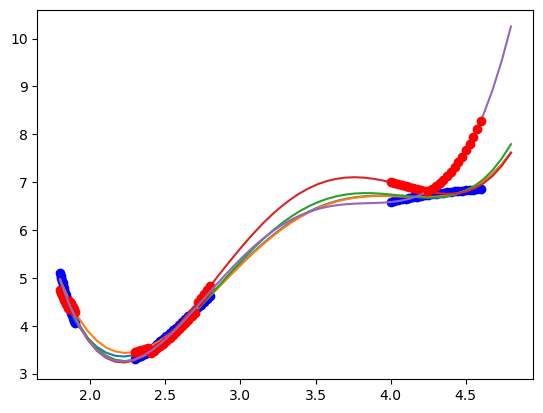

In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

Xfit = np.linspace(1.8, 4.8)[:, None]
plt.plot(X, y, "bo")

for train, test in kf.split(X):
    pipe.fit(X[train], y[train])
    plt.plot(Xfit, pipe.predict(Xfit))
    plt.plot(X[test], pipe.predict(X[test]), "ro")
    print(pipe.score(X[train], y[train]), pipe.score(X[test], y[test]))

You can see here that the results depend on the specific data set that is chosen. In every case, the score of the train data is ok, but for some models the test data is not as good. This is commonly observed, and it indicates over-fitting in the train data, and poor generalization in the test data.

A common metric for judging the fit is called the cross-validation score. This is obtained by averaging the score across all the folds. We would like this score to be a minimum for our model.

```{index} cross-validation
```

In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe, X, y, cv=5)
print(scores)
print(f"Accuracy: {scores.mean():0.2f} (+/- {scores.std() * 2:0.2f})")

[-1.94778877e-01  8.30479457e-01  8.74636980e-01  9.45454034e-01
 -3.54966927e+02]
Accuracy: -70.50 (+/- 284.47)


## Hyperparameter optimization



The next goal we have is to figure out what the best polynomial to use might be. We will leverage `sklearn` again to do this search for us. First, we get a list of parameters that we can change in our `pipe`.



In [10]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'poly', 'scale', 'linregress', 'poly__degree', 'poly__include_bias', 'poly__interaction_only', 'poly__order', 'scale__copy', 'scale__with_mean', 'scale__with_std', 'linregress__copy_X', 'linregress__fit_intercept', 'linregress__n_jobs', 'linregress__normalize', 'linregress__positive'])

We want to vary the `poly_degree` parameter to find the one with the best CV score. We make a list of integer values this argument can take.



In [11]:
pdegree = np.arange(4, 15)
param_grid = [{"poly__degree": pdegree}]

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(pipe, param_grid)
clf.fit(X[train], y[train])

print(clf.best_params_)

{'poly__degree': 11}


That tells us an 11th order polynomial is best here. We get a lot of data from this.



In [12]:
clf.cv_results_

{'mean_fit_time': array([0.00616555, 0.0057899 , 0.00552492, 0.00553412, 0.00556197,
        0.00563121, 0.00576525, 0.00604467, 0.00583591, 0.00625091,
        0.00589566]),
 'std_fit_time': array([0.00074243, 0.00033344, 0.00010137, 0.00014263, 0.00012472,
        0.00021662, 0.00029389, 0.00023983, 0.00016329, 0.0003361 ,
        0.0001307 ]),
 'mean_score_time': array([0.00205412, 0.00201645, 0.00210567, 0.00216141, 0.00208588,
        0.00205078, 0.00212159, 0.00212736, 0.00208583, 0.00217457,
        0.00215263]),
 'std_score_time': array([2.12623534e-04, 9.83030305e-05, 8.62171691e-05, 1.19249394e-04,
        1.05984221e-04, 1.46631466e-04, 9.93096925e-05, 7.29563034e-05,
        1.05222371e-04, 1.03021923e-04, 9.31976243e-05]),
 'param_poly__degree': masked_array(data=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object),
 'p

The order 11 is the one that minimizes the average test score *and* std, and is the best compromise on these.



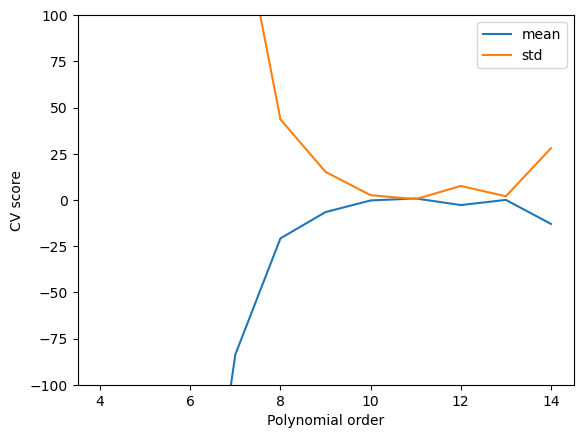

In [14]:
plt.plot(
    pdegree,
    clf.cv_results_["mean_test_score"],
    pdegree,
    clf.cv_results_["std_test_score"],
)
plt.ylim([-100, 100])
plt.legend(["mean", "std"])
plt.xlabel("Polynomial order")
plt.ylabel("CV score");

We can also see here that this is a good compromise. Note, however, we still cannot reliably extrapolate with this model because it is still just a polynomial model, and it does not contain any physics.



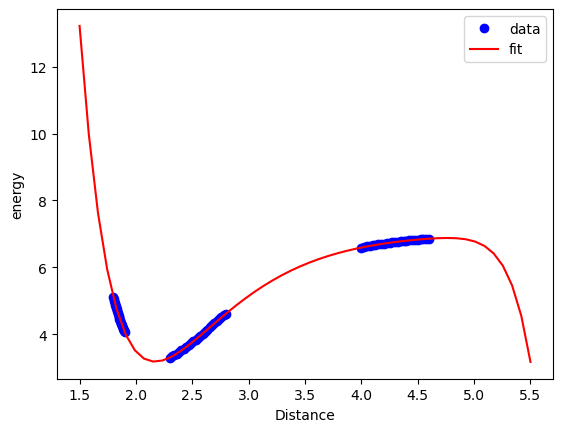

In [15]:
Xfit = np.linspace(1.5, 5.5)[:, None]
plt.plot(X, y, "bo")
plt.plot(Xfit, clf.predict(Xfit), "r-")
plt.xlabel("Distance")
plt.ylabel("energy")
plt.legend(["data", "fit"]);

**Exercises** Read more about these sklearn functions. How would you plot the fit for each polynomial degree?



## Summary



We illustrated how to leverage `sklearn` to do a single hyperparameter optimization here, the polynomial order. Typical machine learning methods have many hyperparameters. We could add new ones here if you include regularization, e.g Lasso, or Ridge would add one more hyperparameter, and Elastic net would add two. Neural networks have hyperparameters that include how many hidden layers, how many neurons per layer, and which activation functions to use. As the number of parameters grow, it is increasingly important to have automated methods for exploring and optimizing them, as well as principled methods for deciding which models are better.

